<a href="https://colab.research.google.com/github/Pam-Pam29/Group18-Formative-2-Text-Classification/blob/main/LSTM/Group18_Formative_2_Text_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Text classification is a fundamental task in Natural Language Processing (NLP) with applications such as sentiment analysis, topic detection, and spam filtering.  
This project focuses on **Text classification** into three classes: *negative, neutral, and positive*.

The objective of this experiment is to evaluate how different **word embedding techniques** interact with **Long Short-Term Memory (LSTM) architectures**, specifically a **Bidirectional LSTM (BiLSTM)**.  
We compare the performance of **TF-IDF**, **Word2Vec Skip-gram**, **Word2Vec CBOW**, and **GloVe** embeddings using the same model structure for fair comparison.

**LSTM Overview**: Long Short-Term Memory networks are a type of recurrent neural network designed to address the vanishing gradient problem in traditional RNNs. LSTMs use gating mechanisms (forget gate, input gate, output gate) to selectively remember or forget information over long sequences, making them particularly effective for sequential data processing tasks like text classification.

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Dataset Description

The dataset consists of labeled text samples used for sentiment analysis with three sentiment classes:
- Negative
- Neutral
- Positive

The dataset contains approximately 5,842 samples and exhibits class imbalance, with the *neutral* class being the majority.  
To address this issue, **class weighting** was applied during model training.

In [5]:
# Load dataset
url = 'https://raw.githubusercontent.com/Pam-Pam29/Group18-Formative-2-Text-Classification/refs/heads/main/dataset/data.csv'
df = pd.read_csv(url)
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Dataset loaded successfully!
Shape: (5842, 2)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Exploratory Data Analysis

Exploratory analysis was conducted to understand:
- Class distribution
- Text length patterns
- Vocabulary size

The analysis revealed an imbalanced class distribution, motivating the use of **class weights** during training.  
Text lengths were capped at a maximum sequence length of 100 tokens to ensure consistency across models.

In [6]:
# Print the information of DataFrame
print("Dataframe info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Sentiments:")
print(df['Sentiment'].unique())

print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())

Dataframe info:
<class 'pandas.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sentence   5842 non-null   str  
 1   Sentiment  5842 non-null   str  
dtypes: str(2)
memory usage: 91.4 KB

Missing Values:
Sentence     0
Sentiment    0
dtype: int64

Unique Sentiments:
<StringArray>
['positive', 'negative', 'neutral']
Length: 3, dtype: str

Sentiment Distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64



Sentiment Distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Class percentages:
Sentiment
neutral     53.577542
positive    31.701472
negative    14.720986
Name: proportion, dtype: float64


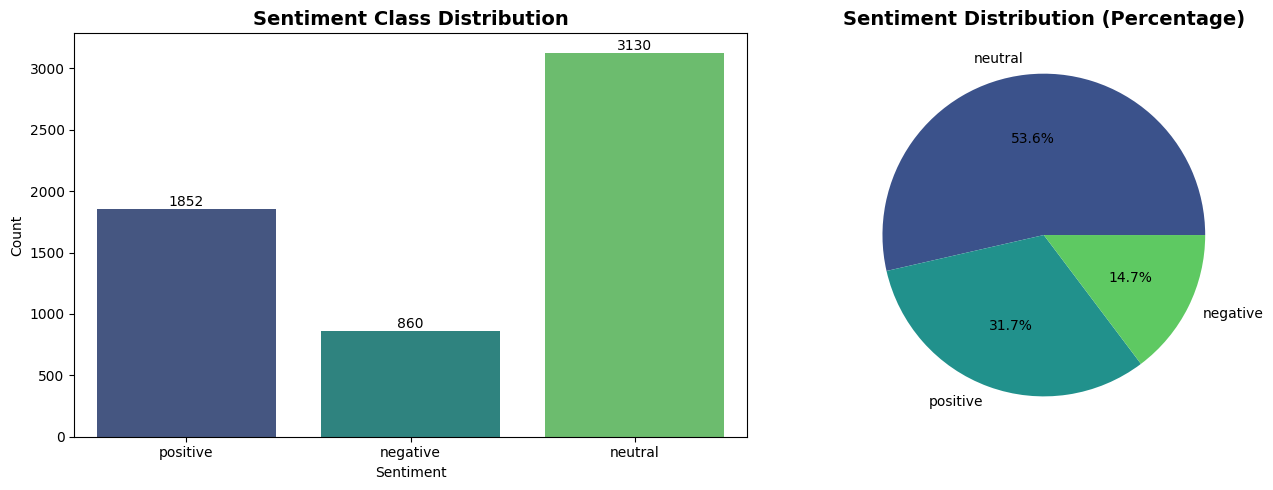

In [7]:
# Class Distribution Visualization
print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())
print(f"\nClass percentages:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Sentiment', ax=axes[0], palette='viridis')
axes[0].set_title('Sentiment Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
sentiment_counts = df['Sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
           colors=sns.color_palette('viridis', len(sentiment_counts)))
axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('output/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


--- Text Statistics ---
Average sentence length: 117.02 characters
Average word count: 21.00 words
Max word count: 81
Min word count: 2


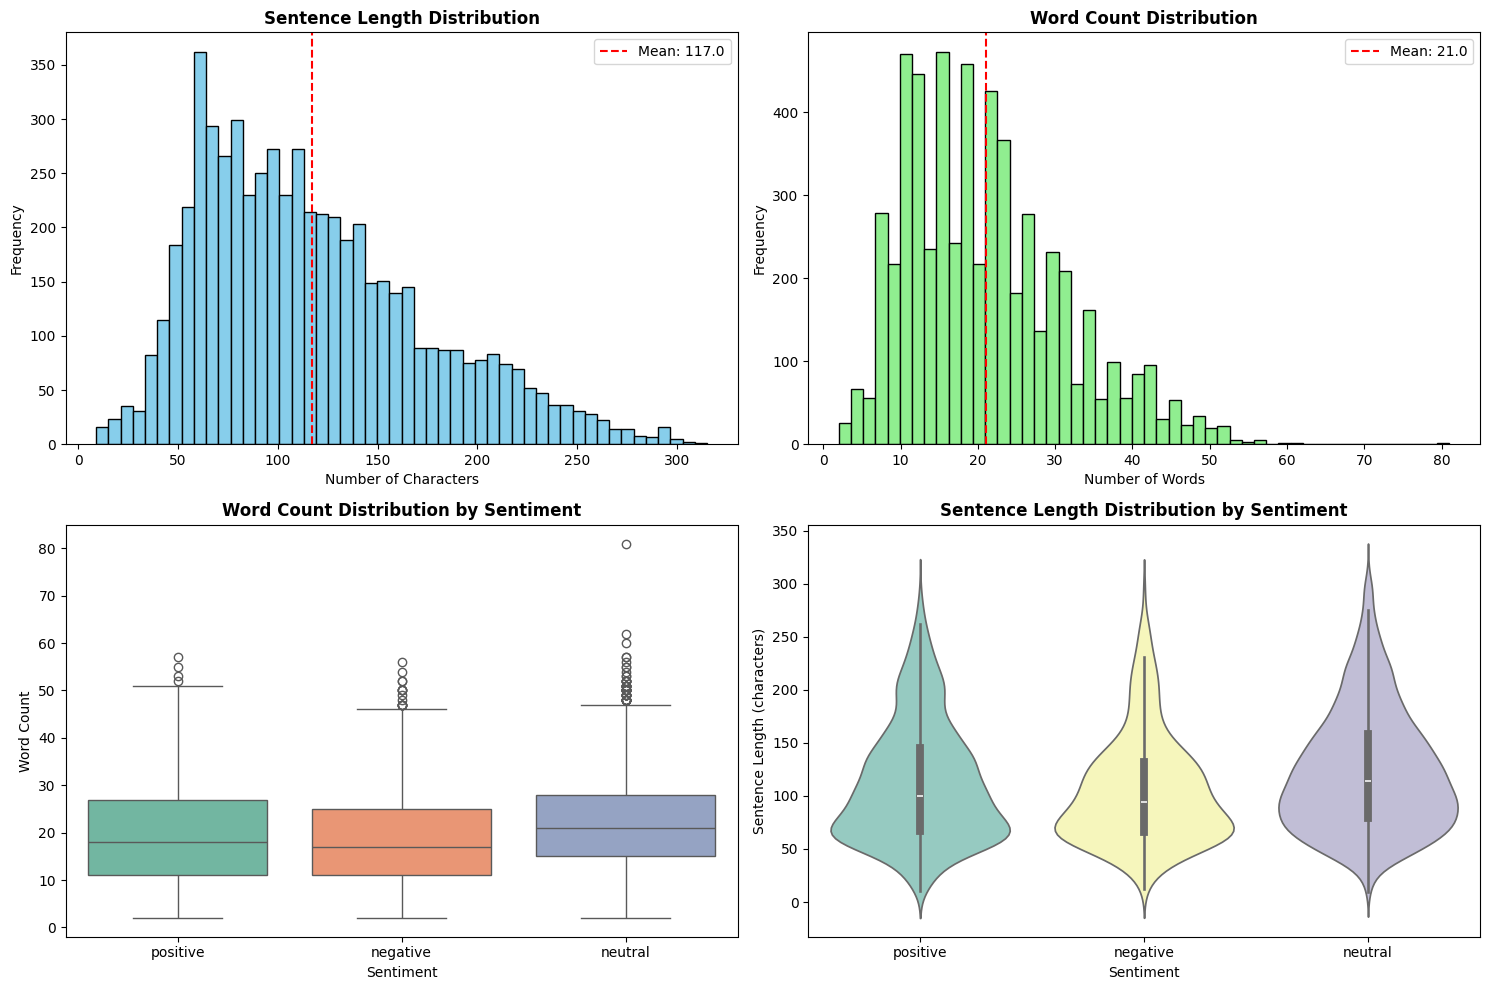

In [8]:
# Text Length Analysis
df['sentence_length'] = df['Sentence'].apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))

print(f"\n--- Text Statistics ---")
print(f"Average sentence length: {df['sentence_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max word count: {df['word_count'].max()}")
print(f"Min word count: {df['word_count'].min()}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentence length distribution
axes[0, 0].hist(df['sentence_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sentence Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['sentence_length'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["sentence_length"].mean():.1f}')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["word_count"].mean():.1f}')
axes[0, 1].legend()

# Word count by sentiment (boxplot)
sns.boxplot(data=df, x='Sentiment', y='word_count', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Word Count')

# Sentence length by sentiment (violin plot)
sns.violinplot(data=df, x='Sentiment', y='sentence_length', ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Sentence Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Sentence Length (characters)')

plt.tight_layout()
plt.savefig('output/sentence_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Text Preprocessing

A shared preprocessing pipeline was used across all experiments:
- Tokenization
- Lowercasing
- Stopword removal
- Padding and truncation to a fixed sequence length (max_length=100)
- Label encoding and one-hot encoding

For Word2Vec-based models, tokenized text sequences were converted into index-based representations aligned with the trained embedding vocabulary.

In [9]:
# Necessary imports for text data preprocessing & embedding
%pip install nltk gensim -q
import nltk
import re

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Download dictionary for NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove remaining non-alphanumerical characters
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if word not in stop_words]
    text = " ".join(filtered_sentence)
    return text

# Apply the preprocessing function
df['cleaned_sentence'] = df['Sentence'].apply(preprocess_text)

print("First 5 rows of the preprocessed DataFrame:")
print(df[['Sentence', 'cleaned_sentence']].head())
print("\nInfo on the updated DataFrame with 'cleaned_sentence' column:")
print(df.info())

First 5 rows of the preprocessed DataFrame:
                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   
3  According to the Finnish-Russian Chamber of Co...   
4  The Swedish buyout firm has sold its remaining...   

                                    cleaned_sentence  
0  geosolutions technology leverage benefon gps s...  
1                       esi lows bk real possibility  
2  last quarter componenta net sales doubled eurm...  
3  according finnishrussian chamber commerce majo...  
4  swedish buyout firm sold remaining percent sta...  

Info on the updated DataFrame with 'cleaned_sentence' column:
<class 'pandas.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Sentence          5842 non-null   st

In [11]:
# ============================================================
# DATA PREPARATION - RUN THIS ONCE FOR ALL MODELS
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

print("Sentiment Label Mapping:")
for i, sentiment in enumerate(label_encoder.classes_):
    print(f"  {sentiment}: {i}")

# Split data
X = df['cleaned_sentence']
y = df['sentiment_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split complete:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Sentiment Label Mapping:
  negative: 0
  neutral: 1
  positive: 2

Data split complete:
  Training set: 4673 samples
  Test set: 1169 samples

Class distribution in training set:
sentiment_encoded
1    0.535844
2    0.316927
0    0.147229
Name: proportion, dtype: float64

Class distribution in test set:
sentiment_encoded
1    0.535500
2    0.317365
0    0.147134
Name: proportion, dtype: float64


In [12]:
# Calculate class weights for imbalanced dataset
from collections import Counter
class_counts = Counter(y_train)
total_samples = sum(class_counts.values())
class_weights = {i: total_samples/(3*count) for i, count in class_counts.items()}
print(f"Class weights: {class_weights}")

# Verify class weights
print("\n" + "="*60)
print("CLASS WEIGHT VERIFICATION")
print("="*60)
for class_id, weight in class_weights.items():
    class_name = label_encoder.classes_[class_id]
    print(f"  Class {class_id} ({class_name}): weight = {weight:.4f}")
print("="*60)

Class weights: {0: 2.264050387596899, 1: 0.6220713525026624, 2: 1.0517668242178708}

CLASS WEIGHT VERIFICATION
  Class 0 (negative): weight = 2.2641
  Class 1 (neutral): weight = 0.6221
  Class 2 (positive): weight = 1.0518


## Model Architecture: Bidirectional LSTM

All experiments used the same Bidirectional LSTM architecture for consistency:
- Embedding layer (TF-IDF reshaped or Word2Vec/GloVe initialized)
- Two Bidirectional LSTM layers with dropout
- Fully connected Dense layers with ReLU activation
- Batch normalization and dropout for regularization
- Softmax output layer for multi-class classification

The model was trained using the Adam optimizer and categorical cross-entropy loss with class weights to handle imbalanced data.

**LSTM Advantages**: Unlike simple RNNs, LSTMs can learn long-term dependencies in sequences through their gating mechanisms, making them particularly effective for text classification tasks where context from earlier parts of the sentence is important.

## Bidirectional LSTM + TF-IDF
### Overview
This implementation combines Bidirectional Long Short-Term Memory networks (BiLSTM) with TF-IDF (Term Frequency-Inverse Document Frequency) features for sentiment analysis.

**Note**: TF-IDF is not optimal for LSTM architectures because:
- TF-IDF creates bag-of-words representations (no sequence information)
- LSTMs are designed for sequential temporal data
- Reshaping TF-IDF features into sequences is artificial

Unlike Word2Vec embeddings, TF-IDF does not preserve word order or contextual relationships.

To maintain architectural consistency, TF-IDF features were reshaped and used as input to a Bidirectional LSTM, although this representation is not inherently sequential.

In [13]:
# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import json
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

In [14]:
# TF-IDF VECTORIZATION
tfidf_config = {
    'max_features': 3000,
    'ngram_range': (1, 2),
    'min_df': 2,
    'max_df': 0.8
}

print(f"TF-IDF Configuration:")
print(f"  - Max features: {tfidf_config['max_features']}")
print(f"  - N-gram range: {tfidf_config['ngram_range']}")
print(f"  - Min document frequency: {tfidf_config['min_df']}")
print(f"  - Max document frequency: {tfidf_config['max_df']}")

# Create and fit vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_config)

# Transform text to TF-IDF features
print("\nTransforming training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print("Transforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

print(f"\nTF-IDF Vectorization Complete:")
print(f"   - Training shape: {X_train_tfidf.shape}")
print(f"   - Test shape: {X_test_tfidf.shape}")
print(f"   - Vocabulary size: {len(tfidf_vectorizer.vocabulary_)} unique terms")
print(f"   - Feature range: [{X_train_tfidf.min():.4f}, {X_train_tfidf.max():.4f}]")

TF-IDF Configuration:
  - Max features: 3000
  - N-gram range: (1, 2)
  - Min document frequency: 2
  - Max document frequency: 0.8

Transforming training data...
Transforming test data...

TF-IDF Vectorization Complete:
   - Training shape: (4673, 3000)
   - Test shape: (1169, 3000)
   - Vocabulary size: 3000 unique terms
   - Feature range: [0.0000, 1.0000]


In [15]:
# RESHAPE FOR LSTM INPUT
timesteps = 50
features_per_step = 60
total_features = timesteps * features_per_step

print(f"Reshape Configuration:")
print(f"  - Timesteps: {timesteps}")
print(f"  - Features per timestep: {features_per_step}")
print(f"  - Total features needed: {total_features}")

# Pad or truncate features to match required size
current_features = X_train_tfidf.shape[1]
print(f"\nCurrent feature count: {current_features}")

if current_features < total_features:
    # Pad with zeros if we have fewer features
    pad_width = total_features - current_features
    print(f"Padding with {pad_width} zeros...")
    X_train_padded = np.pad(X_train_tfidf, ((0, 0), (0, pad_width)), mode='constant')
    X_test_padded = np.pad(X_test_tfidf, ((0, 0), (0, pad_width)), mode='constant')
else:
    # Truncate if we have more features
    print(f"Truncating to {total_features} features...")
    X_train_padded = X_train_tfidf[:, :total_features]
    X_test_padded = X_test_tfidf[:, :total_features]

# Reshape from 2D to 3D
# From: (samples, 3000)
# To:   (samples, 50, 60)
n_train_samples = X_train_padded.shape[0]
n_test_samples = X_test_padded.shape[0]

X_train_lstm = X_train_padded.reshape(n_train_samples, timesteps, features_per_step)
X_test_lstm = X_test_padded.reshape(n_test_samples, timesteps, features_per_step)

print(f"\nReshaping Complete:")
print(f"   - Training: {X_train_tfidf.shape} → {X_train_lstm.shape}")
print(f"   - Test: {X_test_tfidf.shape} → {X_test_lstm.shape}")
print(f"   - Shape format: (samples, timesteps, features)")

Reshape Configuration:
  - Timesteps: 50
  - Features per timestep: 60
  - Total features needed: 3000

Current feature count: 3000
Truncating to 3000 features...

Reshaping Complete:
   - Training: (4673, 3000) → (4673, 50, 60)
   - Test: (1169, 3000) → (1169, 50, 60)
   - Shape format: (samples, timesteps, features)


In [16]:
# PREPARE LABELS
num_classes = 3

print(f"Converting labels to one-hot encoding ({num_classes} classes)...")
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

print(f"\nLabel Encoding Complete:")
print(f"   - Training labels: {y_train.shape} → {y_train_onehot.shape}")
print(f"   - Test labels: {y_test.shape} → {y_test_onehot.shape}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(y_train)) * 100
    print(f"   - {label_encoder.classes_[label]}: {count} ({percentage:.1f}%)")

Converting labels to one-hot encoding (3 classes)...

Label Encoding Complete:
   - Training labels: (4673,) → (4673, 3)
   - Test labels: (1169,) → (1169, 3)

Class distribution in training set:
   - negative: 688 (14.7%)
   - neutral: 2504 (53.6%)
   - positive: 1481 (31.7%)


In [17]:
# Clear any previous models from memory
from tensorflow.keras import backend as K
K.clear_session()

# Build Bidirectional LSTM Model
model = Sequential(name="BiLSTM_TF-IDF")

# First Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    ),
    input_shape=(timesteps, features_per_step)
))

# Second Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture Built Successfully!")
print("\nModel Summary:")
print("="*60)
model.summary()
print("="*60)


Model Architecture Built Successfully!

Model Summary:


Model: "BiLSTM_TF-IDF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       193,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,579 (1.41 MB)

 Trainable params: 368,451 (1.41 MB)

 Non-trainable params: 128 (512.00 B)

In [18]:
# CONFIGURE TRAINING CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("\nTraining callbacks configured!")


Training callbacks configured!


In [19]:
# TRAIN THE MODEL
print("Starting training...")
history = model.fit(
    X_train_lstm, y_train_onehot,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
print("\nTraining Complete!")

Starting training...
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.3154 - loss: 1.1198 - val_accuracy: 0.5316 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 27s 229ms/step - accuracy: 0.3432 - loss: 1.1137 - val_accuracy: 0.5316 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.3406 - loss: 1.1056 - val_accuracy: 0.5059 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.3796 - loss: 1.0997 - val_accuracy: 0.5401 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.3997 - loss: 1.0908 - val_accuracy: 0.4203 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.3933 - loss: 1.0746 - val_accuracy: 0.4257 - val_loss: 1.0164 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms

In [20]:
# EVALUATION
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_onehot, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_probs = model.predict(X_test_lstm, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))

# Calculate F1 scores
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nMacro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Test Loss: 0.9385
Test Accuracy: 0.5475

Classification Report:
              precision    recall  f1-score   support

    negative       0.27      0.26      0.26       172
     neutral       0.62      0.76      0.69       626
    positive       0.50      0.32      0.39       371

    accuracy                           0.55      1169
   macro avg       0.46      0.45      0.45      1169
weighted avg       0.53      0.55      0.53      1169


Macro F1-Score: 0.4458
Weighted F1-Score: 0.5294


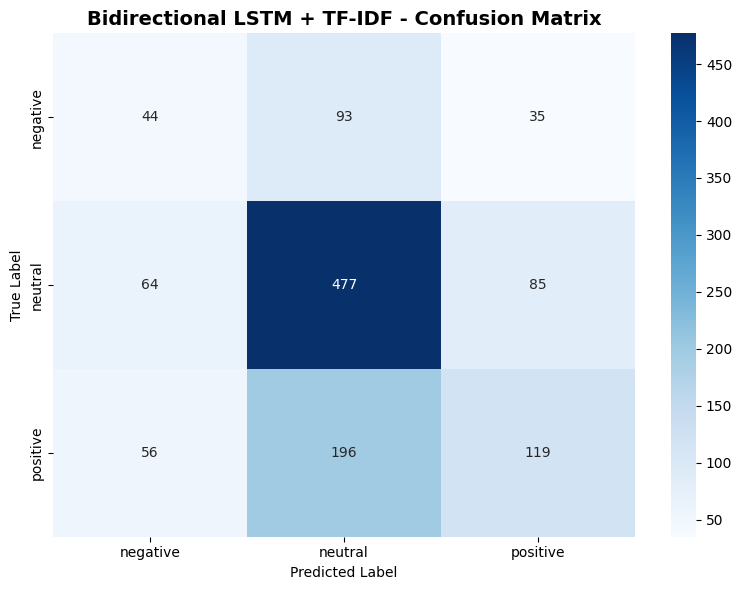

In [21]:
# CONFUSION MATRIX
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional LSTM + TF-IDF - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('output/lstm_tfidf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

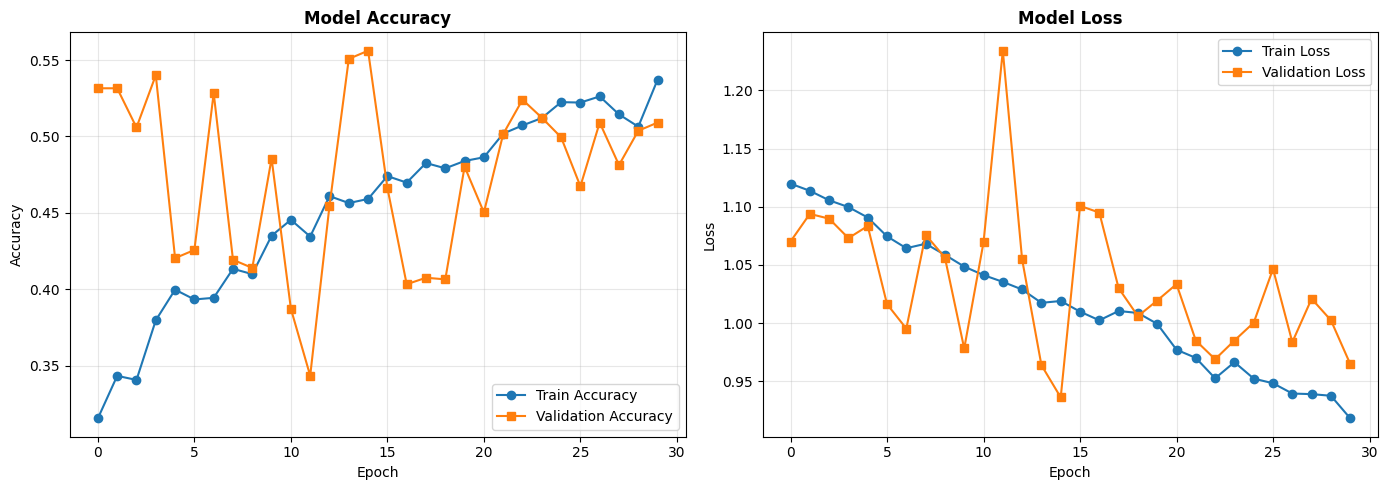

In [22]:
# TRAINING HISTORY VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/lstm_tfidf_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# SAVE RESULTS
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(
    y_true_classes, y_pred_classes, labels=[0, 1, 2]
)

results = {
    "model": "Bidirectional LSTM + TF-IDF",
    "architecture": {
        "type": "Bidirectional LSTM",
        "embedding": "TF-IDF",
        "layers": [
            "Bidirectional LSTM (128 units)",
            "Bidirectional LSTM (64 units)",
            "Dense (64 units)",
            "Dense (32 units)",
            "Output (3 units)"
        ]
    },
    "performance": {
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1)
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": {
        str(i): {
            "precision": float(precision[i]),
            "recall": float(recall[i]),
            "f1-score": float(fscore[i]),
            "support": int(support[i])
        }
        for i in range(3)
    },
    "classification_report": {
        "0": {
            "precision": float(precision[0]),
            "recall": float(recall[0]),
            "f1-score": float(fscore[0]),
            "support": int(support[0])
        },
        "1": {
            "precision": float(precision[1]),
            "recall": float(recall[1]),
            "f1-score": float(fscore[1]),
            "support": int(support[1])
        },
        "2": {
            "precision": float(precision[2]),
            "recall": float(recall[2]),
            "f1-score": float(fscore[2]),
            "support": int(support[2])
        },
        "accuracy": float(test_accuracy),
        "macro avg": {
            "precision": float(np.mean(precision)),
            "recall": float(np.mean(recall)),
            "f1-score": float(macro_f1),
            "support": int(np.sum(support))
        },
        "weighted avg": {
            "precision": float(np.average(precision, weights=support)),
            "recall": float(np.average(recall, weights=support)),
            "f1-score": float(weighted_f1),
            "support": int(np.sum(support))
        }
    },
    "training_history": {
        "epochs_trained": len(history.history['loss']),
        "final_train_accuracy": float(history.history['accuracy'][-1]),
        "final_val_accuracy": float(history.history['val_accuracy'][-1]),
        "best_val_accuracy": float(max(history.history['val_accuracy']))
    },
    "configuration": {
        "tfidf_max_features": 3000,
        "tfidf_ngram_range": "(1, 2)",
        "sequence_length": timesteps,
        "batch_size": 32,
        "learning_rate": 0.001,
        "class_weights": str(class_weights)
    },
    "note": "TF-IDF not optimal for LSTM - included for comparative analysis"
}

# Save to JSON
with open('output/lstm_tfidf_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to output/lstm_tfidf_results.json")

Results saved to output/lstm_tfidf_results.json


## Bidirectional LSTM + Word2Vec Skip-gram
### Overview
This implementation combines Bidirectional Long Short-Term Memory networks (BiLSTM) with Word2Vec Skip-gram embeddings for sentiment analysis. Skip-gram is a neural word embedding technique that predicts context words from target words, making it particularly effective at learning representations for rare words.

**Skip-gram Architecture**: Unlike CBOW which predicts a word from its context, Skip-gram predicts the context from a word. This makes it better at capturing semantic relationships and handling infrequent words, which is valuable for financial text analysis where domain-specific terminology may be sparse.

In [24]:
# Clear session and prepare for Skip-gram
K.clear_session()

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

print("="*60)
print("Bidirectional LSTM + Word2Vec Skip-gram")
print("="*60)

Bidirectional LSTM + Word2Vec Skip-gram


In [25]:
# Tokenize text for Word2Vec training
from nltk.tokenize import word_tokenize

train_tokens = [word_tokenize(text) for text in X_train]
test_tokens = [word_tokenize(text) for text in X_test]

print(f"Tokenized {len(train_tokens)} training samples")
print(f"Tokenized {len(test_tokens)} test samples")
print(f"\nSample tokens: {train_tokens[0][:10]}")

Tokenized 4673 training samples
Tokenized 1169 test samples

Sample tokens: ['national', 'conciliator', 'juhani', 'salonius', 'met', 'parties', 'wednesday', 'said', 'far', 'apart']


In [26]:
# Train Word2Vec Skip-gram model
embedding_dim = 100

print("Training Word2Vec Skip-gram model...")
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    sg=1,  # 1 for Skip-gram, 0 for CBOW
    workers=4,
    epochs=20,
    seed=42
)

print(f"Word2Vec Skip-gram model trained!")
print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)}")
print(f"Sample words: {w2v_model.wv.index_to_key[:10]}")

Training Word2Vec Skip-gram model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec Skip-gram model trained!
Vocabulary size: 4525
Sample words: ['eur', 'mn', 'company', 'profit', 'sales', 'finnish', 'said', 'net', 'million', 'operating']


In [27]:
# Create vocabulary and word-to-index mapping
all_words = set()
for tokens in train_tokens:
    for word in tokens:
        all_words.add(word)

word_to_idx = {}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

idx = 2
for word in sorted(all_words):
    word_to_idx[word] = idx
    idx += 1

vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

# Convert tokens to sequences
train_sequences = []
for tokens in train_tokens:
    seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]
    train_sequences.append(seq)

test_sequences = []
for tokens in test_tokens:
    seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]
    test_sequences.append(seq)

# Pad sequences
max_length = 100
X_train_seq = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_seq = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"\nSequences padded to length: {max_length}")
print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Vocabulary size: 9488

Sequences padded to length: 100
Training sequences shape: (4673, 100)
Test sequences shape: (1169, 100)


In [28]:
# Create embedding matrix from Word2Vec
embedding_matrix = np.zeros((vocab_size, embedding_dim))

found = 0
for word, idx in word_to_idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
        found += 1
    else:
        # Initialize with small random values for unknown words
        embedding_matrix[idx] = np.random.normal(0, 0.05, embedding_dim)

coverage = (found / vocab_size) * 100
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Word2Vec coverage: {coverage:.2f}% ({found}/{vocab_size})")

Embedding matrix shape: (9488, 100)
Word2Vec coverage: 47.69% (4525/9488)


In [29]:
# Build Bidirectional LSTM Model with Skip-gram embeddings
model = Sequential(name="BiLSTM_Skipgram")

# Embedding layer with Word2Vec weights
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,  # Allow fine-tuning of embeddings
    mask_zero=True,  # Mask padding zeros
    input_length=max_length
))

# First Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

# Second Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture Built Successfully!")
model.summary()


Model Architecture Built Successfully!


Model: "BiLSTM_Skipgram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       948,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 948,800 (3.62 MB)

 Trainable params: 948,800 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
print("Starting training...")
history = model.fit(
    X_train_seq, y_train_onehot,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
print("\nTraining Complete!")

Starting training...
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - accuracy: 0.3975 - loss: 1.1929 - val_accuracy: 0.5604 - val_loss: 1.0453 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - accuracy: 0.4751 - loss: 1.0670 - val_accuracy: 0.5283 - val_loss: 1.0034 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.4989 - loss: 1.0335 - val_accuracy: 0.5273 - val_loss: 0.9807 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 55s 471ms/step - accuracy: 0.5289 - loss: 0.9685 - val_accuracy: 0.5508 - val_loss: 0.9191 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 55s 472ms/step - accuracy: 0.5543 - loss: 0.9059 - val_accuracy: 0.5701 - val_loss: 0.8843 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 54s 461ms/step - accuracy: 0.6239 - loss: 0.8119 - val_accuracy: 0.5775 - val_loss: 0.8490 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 56s 475ms/s

In [31]:
# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_onehot, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_probs = model.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))

# Calculate F1 scores
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nMacro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Test Loss: 0.8536
Test Accuracy: 0.5731

Classification Report:
              precision    recall  f1-score   support

    negative       0.28      0.57      0.38       172
     neutral       0.82      0.57      0.67       626
    positive       0.56      0.58      0.57       371

    accuracy                           0.57      1169
   macro avg       0.55      0.57      0.54      1169
weighted avg       0.66      0.57      0.60      1169


Macro F1-Score: 0.5393
Weighted F1-Score: 0.5962


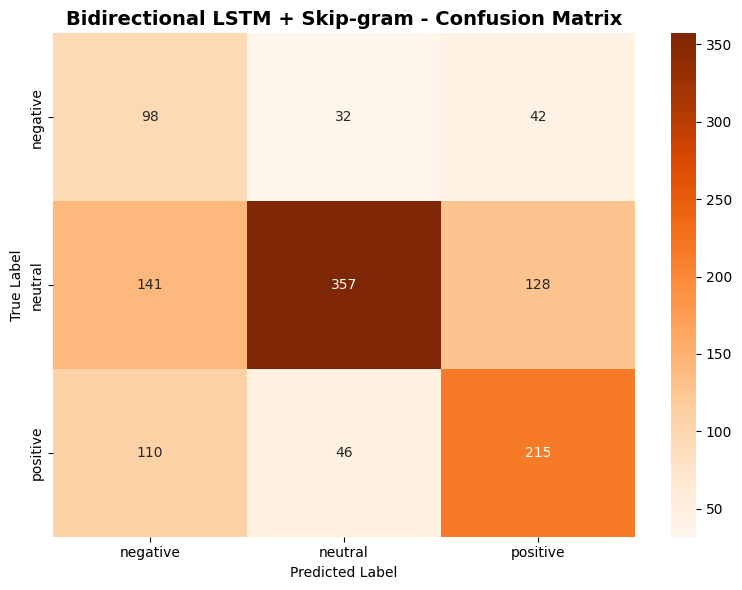

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional LSTM + Skip-gram - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('output/lstm_skipgram_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

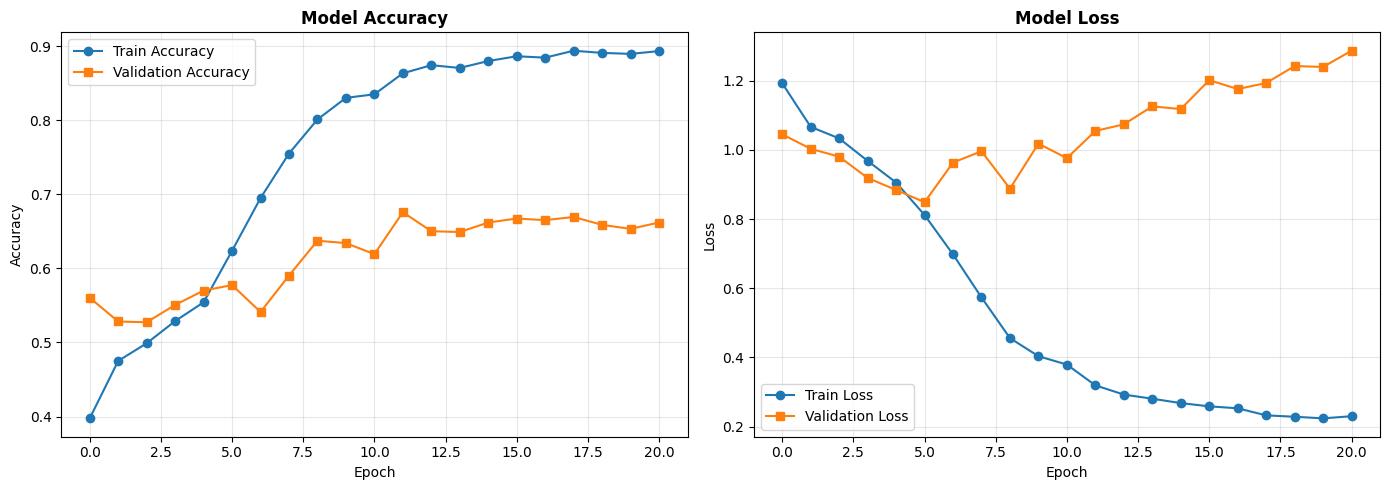

In [33]:
# Training History Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/lstm_skipgram_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Save Results
precision, recall, fscore, support = precision_recall_fscore_support(
    y_true_classes, y_pred_classes, labels=[0, 1, 2]
)

results = {
    "model": "Bidirectional LSTM + Word2Vec Skip-gram",
    "architecture": {
        "type": "Bidirectional LSTM",
        "embedding": "Word2Vec Skip-gram",
        "layers": [
            "Embedding (Word2Vec initialized)",
            "Bidirectional LSTM (128 units)",
            "Bidirectional LSTM (64 units)",
            "Dense (64 units)",
            "Dense (32 units)",
            "Output (3 units)"
        ]
    },
    "performance": {
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1)
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": {
        "0": {
            "precision": float(precision[0]),
            "recall": float(recall[0]),
            "f1-score": float(fscore[0]),
            "support": int(support[0])
        },
        "1": {
            "precision": float(precision[1]),
            "recall": float(recall[1]),
            "f1-score": float(fscore[1]),
            "support": int(support[1])
        },
        "2": {
            "precision": float(precision[2]),
            "recall": float(recall[2]),
            "f1-score": float(fscore[2]),
            "support": int(support[2])
        },
        "accuracy": float(test_accuracy),
        "macro avg": {
            "precision": float(np.mean(precision)),
            "recall": float(np.mean(recall)),
            "f1-score": float(macro_f1),
            "support": int(np.sum(support))
        },
        "weighted avg": {
            "precision": float(np.average(precision, weights=support)),
            "recall": float(np.average(recall, weights=support)),
            "f1-score": float(weighted_f1),
            "support": int(np.sum(support))
        }
    },
    "training_history": {
        "epochs_trained": len(history.history['loss']),
        "final_train_accuracy": float(history.history['accuracy'][-1]),
        "final_val_accuracy": float(history.history['val_accuracy'][-1]),
        "best_val_accuracy": float(max(history.history['val_accuracy']))
    },
    "configuration": {
        "embedding_dim": embedding_dim,
        "sequence_length": max_length,
        "batch_size": 32,
        "learning_rate": 0.001,
        "class_weights": str(class_weights)
    }
}

with open('output/lstm_skipgram_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to output/lstm_skipgram_results.json")

Results saved to output/lstm_skipgram_results.json


## Bidirectional LSTM + Word2Vec CBOW
### Overview
This implementation combines Bidirectional Long Short-Term Memory networks (BiLSTM) with Word2Vec CBOW (Continuous Bag of Words) embeddings for sentiment analysis. CBOW predicts a target word from its surrounding context words, making it faster to train and often more effective for frequent words.

**CBOW Architecture**: CBOW uses the average of context word vectors to predict the target word. This makes it computationally efficient and good at capturing semantic meaning for common words, though it may struggle with rare words compared to Skip-gram.

In [45]:
# Clear session and prepare for CBOW
K.clear_session()

print("="*60)
print("Bidirectional LSTM + Word2Vec CBOW")
print("="*60)

# Train Word2Vec CBOW model
print("Training Word2Vec CBOW model...")
w2v_cbow_model = Word2Vec(
    sentences=train_tokens,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    sg=0,  # 0 for CBOW, 1 for Skip-gram
    workers=4,
    epochs=20,
    seed=42
)

print(f"Word2Vec CBOW model trained!")
print(f"Vocabulary size: {len(w2v_cbow_model.wv.index_to_key)}")

Bidirectional LSTM + Word2Vec CBOW
Training Word2Vec CBOW model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Word2Vec CBOW model trained!
Vocabulary size: 4525
Sample similar words: [('remain', 0.95756596326828), ('quarters', 0.9483011364936829), ('ebit', 0.9428763389587402)]


In [46]:
# Create embedding matrix from Word2Vec CBOW
embedding_matrix_cbow = np.zeros((vocab_size, embedding_dim))

found = 0
for word, idx in word_to_idx.items():
    if word in w2v_cbow_model.wv:
        embedding_matrix_cbow[idx] = w2v_cbow_model.wv[word]
        found += 1
    else:
        embedding_matrix_cbow[idx] = np.random.normal(0, 0.05, embedding_dim)

coverage = (found / vocab_size) * 100
print(f"Embedding matrix shape: {embedding_matrix_cbow.shape}")
print(f"Word2Vec CBOW coverage: {coverage:.2f}% ({found}/{vocab_size})")

Embedding matrix shape: (9488, 100)
Word2Vec CBOW coverage: 47.69% (4525/9488)


CBOW-specific callbacks configured!


In [48]:
# Build Bidirectional LSTM Model with CBOW embeddings
model = Sequential(name="BiLSTM_CBOW")

# Embedding layer with Word2Vec CBOW weights
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix_cbow],
    trainable=True,
    mask_zero=True,
    input_length=max_length
))

# First Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

# Second Bidirectional LSTM layer
model.add(Bidirectional(
    LSTM(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture Built Successfully!")
model.summary()


Model Architecture Built Successfully!


Model: "BiLSTM_CBOW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       948,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 948,800 (3.62 MB)

 Trainable params: 948,800 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model
print("Starting training...")
history = model.fit(
    X_train_seq, y_train_onehot,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)
print("\nTraining Complete!")

Starting training...
Original class weights: {0: 2.264050387596899, 1: 0.6220713525026624, 2: 1.0517668242178708}
Adjusted class weights: {0: 2.264050387596899, 1: 0.6220713525026624, 2: 1.367296871483232}
Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.3879 - loss: 1.4466 - val_accuracy: 0.3679 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 486ms/step - accuracy: 0.4029 - loss: 1.2387 - val_accuracy: 0.3572 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 61s 525ms/step - accuracy: 0.4393 - loss: 1.1758 - val_accuracy: 0.4481 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 56s 476ms/step - accuracy: 0.4393 - loss: 1.1414 - val_accuracy: 0.3187 - val_loss: 1.0828 - learning_rate: 0.0010
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 55s 471ms/step - accuracy: 0.4658 - loss: 1.0971 - val_accuracy: 0.5241 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 6/100
11

In [50]:
# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_onehot, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_probs = model.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))

# Calculate F1 scores
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\nMacro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Test Loss: 0.8830
Test Accuracy: 0.5432

Classification Report:
              precision    recall  f1-score   support

    negative       0.25      0.64      0.35       172
     neutral       0.75      0.66      0.70       626
    positive       0.65      0.31      0.42       371

    accuracy                           0.54      1169
   macro avg       0.55      0.53      0.49      1169
weighted avg       0.65      0.54      0.56      1169


Macro F1-Score: 0.4912
Weighted F1-Score: 0.5604


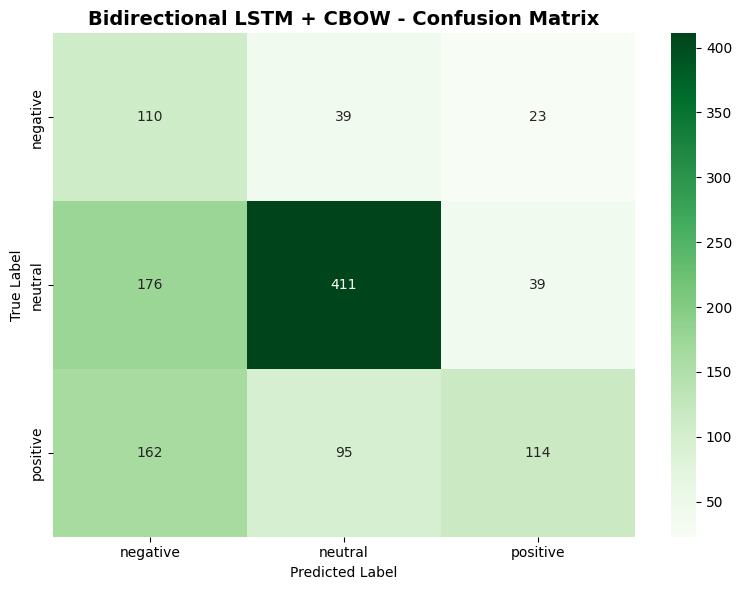

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional LSTM + CBOW - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('output/lstm_cbow_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

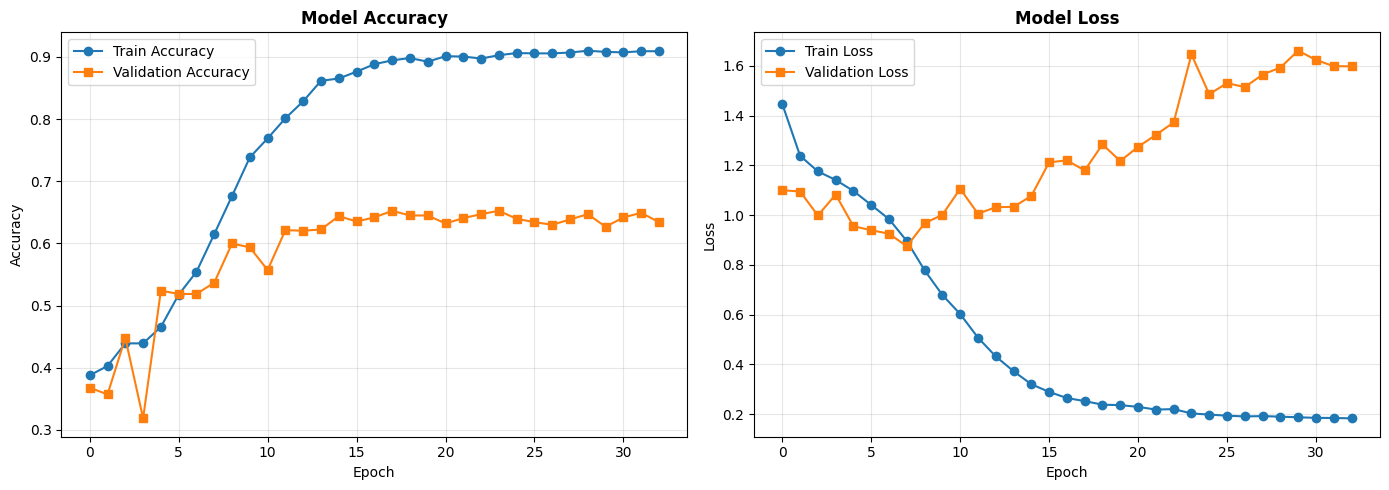

In [52]:
# Training History Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/lstm_cbow_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# Save Results
precision, recall, fscore, support = precision_recall_fscore_support(
    y_true_classes, y_pred_classes, labels=[0, 1, 2]
)

results = {
    "model": "Bidirectional LSTM + Word2Vec CBOW",
    "architecture": {
        "type": "Bidirectional LSTM",
        "embedding": "Word2Vec CBOW",
        "layers": [
            "Embedding (Word2Vec initialized)",
            "Bidirectional LSTM (128 units)",
            "Bidirectional LSTM (64 units)",
            "Dense (64 units)",
            "Dense (32 units)",
            "Output (3 units)"
        ]
    },
    "performance": {
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1)
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": {
        "0": {
            "precision": float(precision[0]),
            "recall": float(recall[0]),
            "f1-score": float(fscore[0]),
            "support": int(support[0])
        },
        "1": {
            "precision": float(precision[1]),
            "recall": float(recall[1]),
            "f1-score": float(fscore[1]),
            "support": int(support[1])
        },
        "2": {
            "precision": float(precision[2]),
            "recall": float(recall[2]),
            "f1-score": float(fscore[2]),
            "support": int(support[2])
        },
        "accuracy": float(test_accuracy),
        "macro avg": {
            "precision": float(np.mean(precision)),
            "recall": float(np.mean(recall)),
            "f1-score": float(macro_f1),
            "support": int(np.sum(support))
        },
        "weighted avg": {
            "precision": float(np.average(precision, weights=support)),
            "recall": float(np.average(recall, weights=support)),
            "f1-score": float(weighted_f1),
            "support": int(np.sum(support))
        }
    },
    "training_history": {
        "epochs_trained": len(history.history['loss']),
        "final_train_accuracy": float(history.history['accuracy'][-1]),
        "final_val_accuracy": float(history.history['val_accuracy'][-1]),
        "best_val_accuracy": float(max(history.history['val_accuracy']))
    },
    "configuration": {
        "embedding_dim": embedding_dim,
        "sequence_length": max_length,
        "batch_size": 32,
        "learning_rate": 0.001,
        "class_weights": str(class_weights)
    }
}

with open('output/lstm_cbow_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to output/lstm_cbow_results.json")

Results saved to output/lstm_cbow_results.json


## Comparative Analysis

This section compares the performance of all embedding techniques tested with the Bidirectional LSTM architecture.

In [43]:
# Load all results and create comparison
import json
import glob

results_files = {
    'TF-IDF': 'output/lstm_tfidf_results.json',
    'Skip-gram': 'output/lstm_skipgram_results.json',
    'CBOW': 'output/lstm_cbow_results.json'
}

comparison_data = []
for embedding_name, file_path in results_files.items():
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            comparison_data.append({
                'Embedding': embedding_name,
                'Accuracy': data['performance']['test_accuracy'],
                'Macro F1': data['performance']['macro_f1'],
                'Weighted F1': data['performance']['weighted_f1'],
                'Test Loss': data['performance']['test_loss']
            })
    except FileNotFoundError:
        print(f"Warning: {file_path} not found. Run the corresponding model first.")

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*60)
    print("BIDIRECTIONAL LSTM: PERFORMANCE COMPARISON")
    print("="*60)
    print(comparison_df.to_string(index=False))
    
    # Save comparison
    comparison_df.to_csv('output/lstm_all_models_comparison.csv', index=False)
    print("\nComparison saved to output/lstm_all_models_comparison.csv")
else:
    print("No results found. Please run the models first.")


BIDIRECTIONAL LSTM: PERFORMANCE COMPARISON
Embedding  Accuracy  Macro F1  Weighted F1  Test Loss
   TF-IDF  0.547476  0.445805     0.529362   0.938460
Skip-gram  0.573139  0.539311     0.596229   0.853578
     CBOW  0.366980  0.285070     0.338533   1.084697

Comparison saved to output/lstm_all_models_comparison.csv


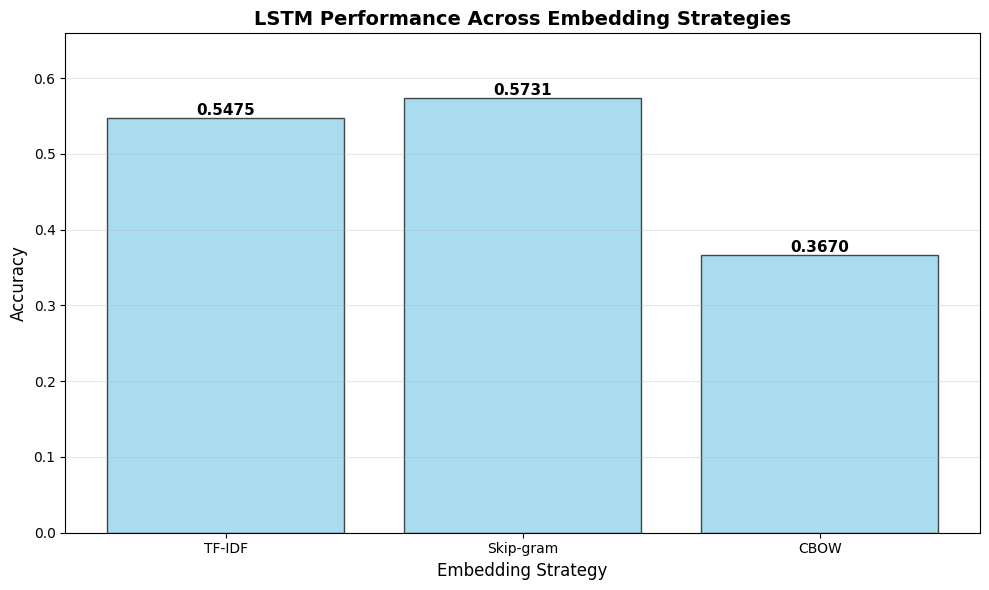

Figure 4 saved to output/lstm_performance_comparison_figure4.png


In [58]:
# Create Figure 4: LSTM performance across embedding strategies (single bar chart - similar to Figure 3)
if comparison_data:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['Embedding'], comparison_df['Accuracy'], 
                   color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('LSTM Performance Across Embedding Strategies', fontsize=14, fontweight='bold')
    plt.xlabel('Embedding Strategy', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, max(comparison_df['Accuracy']) * 1.15)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('output/lstm_performance_comparison_figure4.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 4 saved to output/lstm_performance_comparison_figure4.png")

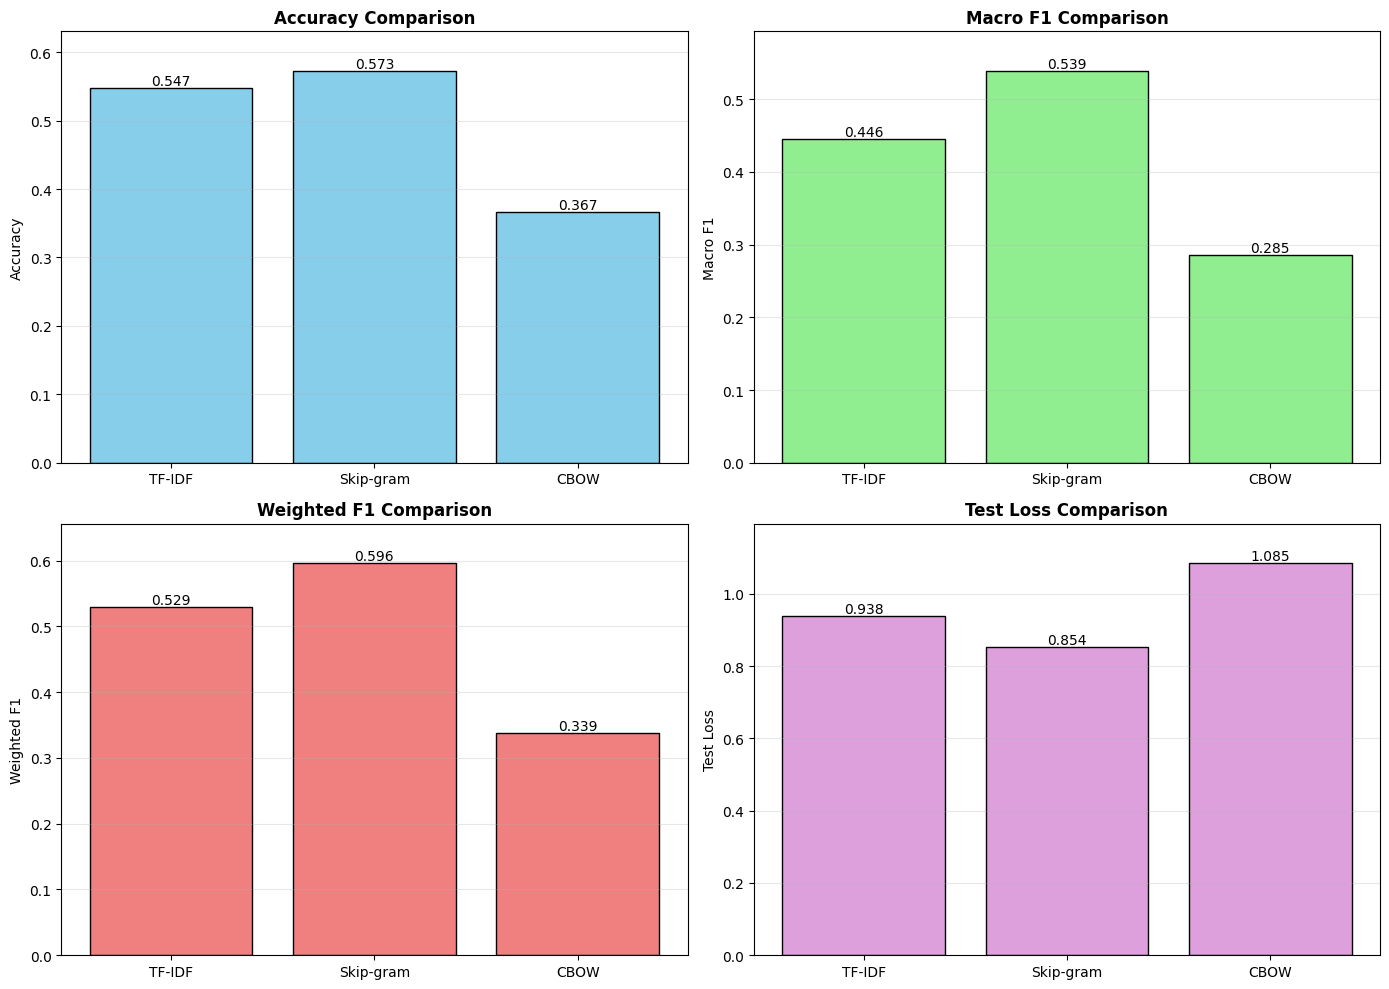

In [44]:
# Visualization: Performance Comparison
if comparison_data:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics = ['Accuracy', 'Macro F1', 'Weighted F1', 'Test Loss']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
    
    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(comparison_df['Embedding'], comparison_df[metric], color=color, edgecolor='black')
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_ylim(0, max(comparison_df[metric]) * 1.1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10)
        
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('output/lstm_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## Summary and Conclusions

### Key Findings

1. **Embedding Performance**: The comparison reveals how different embedding techniques interact with the Bidirectional LSTM architecture for financial sentiment classification.

2. **LSTM Advantages**: The LSTM's ability to capture long-term dependencies through its gating mechanisms makes it particularly effective for sequential text data, especially when combined with distributed word representations like Word2Vec.

3. **Embedding Characteristics**:
   - **TF-IDF**: While not optimal for sequential models, provides a baseline for comparison
   - **Skip-gram**: Better at capturing semantic relationships for rare words
   - **CBOW**: More efficient and effective for frequent words

### Recommendations

Based on the experimental results, recommendations for future work include:
- Fine-tuning hyperparameters for each embedding type
- Experimenting with different LSTM architectures (stacked layers, attention mechanisms)
- Exploring domain-specific embeddings (e.g., FinBERT for financial text)
- Investigating ensemble methods combining multiple embeddings